In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP

# Load Data:

In [2]:
conv_mat = load("../data/experiment/m2/conv_matrix-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_3"],
);


In [ ]:
# images = load("../data/experiment/m2/images-2.jld2");

# event_number = 1

# event_data = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_3"][event_number,:,:],
#     charge = images["charge"][event_number,:,:],
# );

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,4))

# ax.pcolormesh(event_data.cam_2)

# Likelihood Function:

In [71]:
function generate_image(
        params::T, 
        population::Float64,
        cv_matrix::Array{Float64,2},
        light_fluctuations::Float64,
        cam_ind::Int64;
        size::Tuple{Int64, Int64}=(101,101),
    ) where {T <: NamedTuple}
    
    image_matrix = zeros(Int64, size...)
    light_coefficient::Float64 = population*params.int_coeff[cam_ind]
    
    δ_x::Float64 = params.δ_x[cam_ind]
    δ_y::Float64 = params.δ_y[cam_ind]
    
    μ_x::Float64  = params.μ_x[cam_ind] * δ_x
    μ_y::Float64  = params.μ_y[cam_ind] * δ_y
    
    σ_x::Float64 = params.tr_size[1] * δ_x
    σ_y::Float64 = params.tr_size[2] * δ_y
    
    σ_x = sqrt.(σ_x^2 + 10^-4*params.ang_spr[1]^2*(params.s_waist[1] - params.s_cam[cam_ind])^2) 
    σ_y = sqrt.(σ_y^2 + 10^-4*params.ang_spr[2]^2*(params.s_waist[1] - params.s_cam[cam_ind])^2) 
    
    @show σ_x, σ_y
    
#     σ_x = sqrt(σ_x^2 + (params.σ_x[cam_ind]*δ_x).^2)
#     σ_y = sqrt(σ_y^2 + (params.σ_y[cam_ind]*δ_y).^2)
    
    bck_cumsum = cumsum(cv_matrix[:,1])
    
    for pix_ind in CartesianIndices(image_matrix)
    
        x_edge::Float64 = pix_ind.I[1] * δ_x
        y_edge::Float64 = pix_ind.I[2] * δ_y

        pix_prediction::Float64 = cdf(Normal(μ_x,σ_x), x_edge) - cdf(Normal(μ_x,σ_x), x_edge - δ_x)
        pix_prediction *= cdf(Normal(μ_y,σ_y), y_edge) - cdf(Normal(μ_y,σ_y), y_edge - δ_y)
        
        pix_prediction = pix_prediction*light_coefficient
        pix_prediction = rand(truncated(Normal(pix_prediction, 1+light_fluctuations*sqrt(pix_prediction)), 0, 4096))
        pix_prediction += argmin(abs.(bck_cumsum .- rand())) - 1
        
        if pix_prediction > 4095
            pix_prediction = 4095
        end
        
        image_matrix[pix_ind] = round(Int64, pix_prediction)
    end

    return image_matrix
end




generate_image (generic function with 1 method)

In [73]:
function generate_event(
        params::D, population::Float64, conv_mat::T
    ) where {T<: NamedTuple, D <: NamedTuple}
    
    size = (60, 60)
    light_fluctuations = 2.0
    
    img_1 = generate_image(params, population, conv_mat.cam_1, light_fluctuations, 1, size = size)
    img_2 = generate_image(params, population, conv_mat.cam_2, light_fluctuations, 2, size = size)
    img_3 = generate_image(params, population, conv_mat.cam_3, light_fluctuations, 3, size = size)
    img_4 = generate_image(params, population, conv_mat.cam_4, light_fluctuations, 4, size = size)
    
    return (img_1, img_2, img_3, img_4)
end

generate_event (generic function with 1 method)

In [76]:
param = (
        tr_size = [6., 6.],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [30,30,30,30], # alignment X
        μ_y = [30,30,30,30], # alignment Y
        σ_x = [0,0,0,0], # resolution X
        σ_y = [0,0,0,0], # resolution Y
        δ_x = [0.0271,0.0216,0.114,0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,0.0298], # pixel size Y
        int_coeff  = [34896.560, 50315.113, 10317.860, 310986.998], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );

In [77]:
toy_event = generate_event(param, 25.0, conv_matrices)

(σ_x, σ_y) = (0.1997367267179474, 0.21666794871415568)
(σ_x, σ_y) = (0.1415326619547587, 0.15148430413742542)
(σ_x, σ_y) = (0.8385223918298188, 0.8931762433025187)
(σ_x, σ_y) = (0.8287853763188635, 0.8281324773247335)


([8 7 … 6 3; 6 3 … 63 4; … ; 0 1 … 316 88; 3 2 … 1 5], [4 3 … 1 3; 264 5 … 0 9; … ; 1 2 … 2 2; 1 2 … 3 2], [3 61 … 7 11; 37 0 … 1 4; … ; 2 30 … 3 344; 54 1 … 0 3], [475 573 … 515 686; 570 621 … 626 657; … ; 742 660 … 736 704; 559 569 … 558 1071])

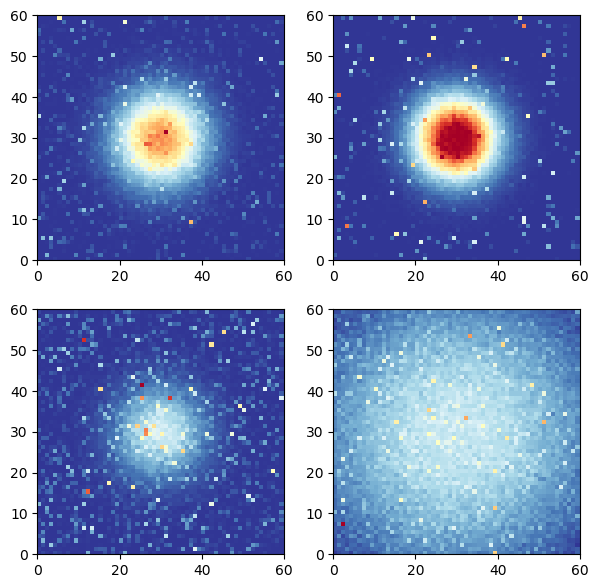

PyObject <matplotlib.collections.QuadMesh object at 0x7ff260c295d0>

In [78]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(toy_event[1], cmap="RdYlBu_r")
ax[1,2].pcolormesh(toy_event[2], cmap="RdYlBu_r")
ax[2,1].pcolormesh(toy_event[3], cmap="RdYlBu_r")
ax[2,2].pcolormesh(toy_event[4], cmap="RdYlBu_r")

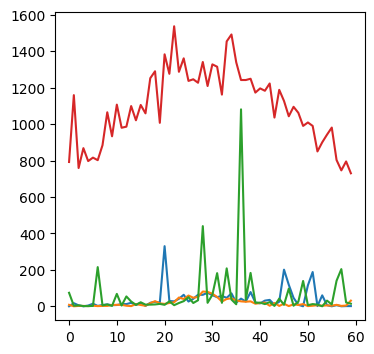

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff260cf2a90>

In [79]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(toy_event[1][:,50])
ax.plot(toy_event[2][:,50])
ax.plot(toy_event[3][:,50])
ax.plot(toy_event[4][:,50])

In [ ]:
img_tmp = generate_image(param, 25.0, conv_matrices.cam_2, 2., 2,)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.pcolormesh(img_tmp, cmap="RdYlBu_r")